In [321]:
import geopandas as gpd
import shapefile as shp
import matplotlib.pyplot as plt
import pandas as pd
import rtree
import seaborn as sns
import matplotlib
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [322]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [323]:
#TV: assume this is output from convert_fewsnet_to_admin2.py
#has data from 07-2009 till 10-2019
#for now assuming convert_fewsnet_to_admin2.py does the thing as described in the proposal
cs = pd.read_csv('Data/EA_FewsNet/FewsNetAdmin2/ethiopia_admin2_fewsnet_20090701_20191001_CS.csv',index_col=0)
ml1 = pd.read_csv('Data/EA_FewsNet/FewsNetAdmin2/ethiopia_admin2_fewsnet_20090701_20191001_ML1.csv',index_col=0)
ml2 = pd.read_csv('Data/EA_FewsNet/FewsNetAdmin2/ethiopia_admin2_fewsnet_20090701_20191001_ML2.csv',index_col=0)

In [324]:
cs.rename(columns={"ADM0_EN":"ADMIN0","ADM1_EN":"ADMIN1","ADM2_EN":"ADMIN2"},inplace=True)
ml1.rename(columns={"ADM0_EN":"ADMIN0","ADM1_EN":"ADMIN1","ADM2_EN":"ADMIN2"},inplace=True)
ml2.rename(columns={"ADM0_EN":"ADMIN0","ADM1_EN":"ADMIN1","ADM2_EN":"ADMIN2"},inplace=True)

In [366]:
ml2.shape[0]/38

91.0

In [325]:
cs.shape

(3458, 5)

In [326]:
ml2.head()

,date,ML2,ADMIN0,ADMIN1,ADMIN2
4212,2011-07-01,3.000,Ethiopia,Somali,Afder
4231,2011-07-01,3.000,Ethiopia,Somali,Liban
4238,2011-07-01,3.000,Ethiopia,Somali,Shabelle
6243,2011-07-01,2.000,Ethiopia,Gambela,Agnewak
4221,2011-07-01,3.000,Ethiopia,Somali,Doolo


In [327]:
ml1.head()

,date,ML1,ADMIN0,ADMIN1,ADMIN2
1874,2011-07-01,3.000,Ethiopia,Somali,Afder
1911,2011-07-01,3.000,Ethiopia,Somali,Liban
94,2011-07-01,4.000,Ethiopia,Somali,Shabelle
6362,2011-07-01,2.000,Ethiopia,Gambela,Agnewak
80,2011-07-01,4.000,Ethiopia,Oromia,Bale


In [367]:
#merge the CS, ML1 and ML2 in one df
df_ipc = cs.merge(ml1[['date', 'ADMIN1','ADMIN2', 'ML1']], on=['ADMIN1','ADMIN2', 'date'], how='left')
df_ipc = df_ipc.merge(ml2[['date', 'ADMIN1','ADMIN2', 'ML2']], on=['ADMIN1','ADMIN2', 'date'], how='left')
df_ipc['date'] = pd.to_datetime(df_ipc['date'])
df_ipc.sort_values('date')

,date,CS,ADMIN0,ADMIN1,ADMIN2,ML1,ML2
227,2009-07-01,4.000,Ethiopia,Somali,Nogob,4.000,4.000
205,2009-07-01,1.000,Ethiopia,Oromia,Finfine Special,1.000,1.000
206,2009-07-01,3.000,Ethiopia,SNNP,Gamo,3.000,2.000
207,2009-07-01,3.000,Ethiopia,SNNP,Gedeo,3.000,3.000
208,2009-07-01,2.000,Ethiopia,SNNP,Gofa,2.000,2.000
...,...,...,...,...,...,...,...
2116,2019-10-01,1.000,Ethiopia,Oromia,Finfine Special,1.000,1.000
2115,2019-10-01,2.000,Ethiopia,Somali,Fafan,2.000,2.000
2114,2019-10-01,3.000,Ethiopia,Somali,Erer,3.000,3.000
2134,2019-10-01,3.000,Ethiopia,Somali,Liban,3.000,3.000


In [368]:
df_ipc.CS.sum()

19007.0

In [369]:
# # mapping names eth pop: fewsnet
admin2_mapping= {'Etang Special':'Etang Special woreda','Zone 4  (Fantana Rasu)':'Zone 4 (Fantana Rasu)'}
# admin2_mapping = {'Zone 1 (Awsi Rasu)': 'Awusi', 'Zone 2 (Kilbet Rasu)': 'Kilbati', 'Zone 3 (Gabi Rasu)': 'Gabi',
#                  'Zone 4  (Fantana Rasu)': 'Fanti', 'Zone 5 (Hari Rasu)': 'Khari', 'Central': 'Central Tigray',
#                  'Eastern': 'East Tigray', 'North Western': 'Northwest Tigray', 'South Eastern': 'Southeast Tigray',
#                  'Western': 'West Tigray', 'Southern': 'South Tigray', 'Mejenger': 'Mezhenger', 'Nuwer': 
#                  'Nuer', 'Etang Special': 'Itang', 'Agnewak': 'Agniwak', 'Dire Dawa rural': 'Dire Dawa', 
#                   'Dire Dawa urban': 'Dire Dawa', 'North Wello': 'North Wollo', 'Wag Hamra': 'Wag Himra',
#                  'Liban': 'Liben', 'Siti': 'Sitti', 'Shabelle': 'Shebelle', 'Doolo': 'Dollo', 'Mao Komo': 'Mao-Komo',
#                  'Halaba Special': 'Alaba', 'Gamo': 'Gamo Gofa', 'Gofa': 'Gamo Gofa', 'Guraghe': 'Gurage',
#                  'Kefa': 'Keffa', 'Dawuro': 'Dawro', 'Ilu Aba Bora': 'Ilubabor'}

# admin1_mapping = {'SNNP': 'SNNPR'}

def get_new_name(name, n_dict):
    if name in n_dict.keys():
        return n_dict[name]
    else:
        return name

In [370]:
# import population data (not clear where data comes from)
eth_pop = pd.read_csv('Data/eth_admpop_adm2_2020.csv')
eth_popn=eth_pop.copy()
#remove whitespace at end of string
eth_popn.admin2Name_en=eth_popn.admin2Name_en.str.rstrip()
eth_popn['admin2Name_en'] = eth_popn['admin2Name_en'].apply(lambda x: get_new_name(x, admin2_mapping))
# eth_popn=eth_pop.copy()
# eth_popn['admin2Name_en'] = eth_pop['admin2Name_en'].apply(lambda x: get_new_name(x, admin2_mapping))
# eth_popn['admin1Name_en'] = eth_pop['admin1Name_en'].apply(lambda x: get_new_name(x, admin1_mapping))
        
eth_popn.head()

,admin2Name_en,admin2Pcode,admin1Name_en,admin1Pcode,admin0Name_en,admin0Pcode,Total,Male,Female,T_00_17,T_18_60,T_60plus
0,Afder,ET0508,Somali,ET05,Ethiopia,ET,654828,352416,302413,347059,276010,31759
1,Agnewak,ET1202,Gambela,ET12,Ethiopia,ET,164054,83695,80359,86948,69149,7957
2,Alle,ET0712,SNNP,ET07,Ethiopia,ET,81190,40595,40595,43031,34221,3938
3,Amaro,ET0721,SNNP,ET07,Ethiopia,ET,195252,97626,97626,103484,82299,9470
4,Arsi,ET0408,Oromia,ET04,Ethiopia,ET,3645492,1829539,1815952,1932111,1536575,176806


In [371]:
len(eth_popn.admin2Name_en.unique())

90

In [372]:
# #to test if different namings of two dataframes
np.setdiff1d(df_ipc.ADMIN2.unique(),eth_popn.admin2Name_en.unique())
# np.setdiff1d(eth_popn.admin2Name_en.unique(),df_ipc.ADMIN2.unique())

array([], dtype=object)

In [373]:
np.setdiff1d(eth_popn.admin2Name_en.unique(),df_ipc.ADMIN2.unique())

array([], dtype=object)

In [374]:
eth_popn[eth_popn.duplicated(['admin2Name_en'])]

,admin2Name_en,admin2Pcode,admin1Name_en,admin1Pcode,admin0Name_en,admin0Pcode,Total,Male,Female,T_00_17,T_18_60,T_60plus
58,North Shewa,ET0406,Oromia,ET04,Ethiopia,ET,1626893,814277,812616,862253,685735,78904


In [375]:
eth_popn[eth_popn.admin2Name_en=="North Shewa"]

,admin2Name_en,admin2Pcode,admin1Name_en,admin1Pcode,admin0Name_en,admin0Pcode,Total,Male,Female,T_00_17,T_18_60,T_60plus
57,North Shewa,ET0305,Amhara,ET03,Ethiopia,ET,2293091,1156744,1136347,1215338,966538,111215
58,North Shewa,ET0406,Oromia,ET04,Ethiopia,ET,1626893,814277,812616,862253,685735,78904


In [376]:
df_ipc[df_ipc.ADMIN2=="North Shewa"].head()

,date,CS,ADMIN0,ADMIN1,ADMIN2,ML1,ML2
46,2010-10-01,3.000,Ethiopia,Amhara,North Shewa,2.000,2.000
47,2010-10-01,2.000,Ethiopia,Oromia,North Shewa,2.000,2.000
137,2009-10-01,2.000,Ethiopia,Amhara,North Shewa,2.000,2.000
138,2009-10-01,2.000,Ethiopia,Oromia,North Shewa,2.000,2.000
228,2009-07-01,2.000,Ethiopia,Amhara,North Shewa,2.000,2.000


In [377]:
#lossing bit of population because of the North Shewa, gotta decide what to do with that 
# eth_popn.loc[eth_popn.admin2Name_en=="North Shewa","admin1Name_en"]="Amhara"

In [378]:
eth_popn[eth_popn.admin2Name_en=="North Shewa"]

,admin2Name_en,admin2Pcode,admin1Name_en,admin1Pcode,admin0Name_en,admin0Pcode,Total,Male,Female,T_00_17,T_18_60,T_60plus
57,North Shewa,ET0305,Amhara,ET03,Ethiopia,ET,2293091,1156744,1136347,1215338,966538,111215
58,North Shewa,ET0406,Oromia,ET04,Ethiopia,ET,1626893,814277,812616,862253,685735,78904


In [379]:
#TV: assume this is the total population in 2020, but doesn't coincide with pop_dict
eth_popn.Total.sum()

99294445

In [380]:
#91 admin2 regions
eth_popn.shape

(91, 12)

In [381]:
df_histpop=pd.read_csv("Data/Worldbank_TotalPopulation.csv",header=2)

In [382]:
df_histpop.set_index("Country Name",inplace=True)

In [383]:
df_histpop.head()

,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,1966,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,Unnamed: 64
Country Name,,,,,,,,,,,,,,,,,,,,,
Aruba,ABW,"Population, total",SP.POP.TOTL,54211.000,55438.000,56225.000,56695.000,57032.000,57360.000,57715.000,...,102046.000,102560.000,103159.000,103774.000,104341.000,104872.000,105366.000,105845.000,106314.000,nan
Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996973.000,9169410.000,9351441.000,9543205.000,9744781.000,9956320.000,10174836.000,...,30117413.000,31161376.000,32269589.000,33370794.000,34413603.000,35383128.000,36296400.000,37172386.000,38041754.000,nan
Angola,AGO,"Population, total",SP.POP.TOTL,5454933.000,5531472.000,5608539.000,5679458.000,5735044.000,5770570.000,5781214.000,...,24220661.000,25107931.000,26015780.000,26941779.000,27884381.000,28842484.000,29816748.000,30809762.000,31825295.000,nan
Albania,ALB,"Population, total",SP.POP.TOTL,1608800.000,1659800.000,1711319.000,1762621.000,1814135.000,1864791.000,1914573.000,...,2905195.000,2900401.000,2895092.000,2889104.000,2880703.000,2876101.000,2873457.000,2866376.000,2854191.000,nan
Andorra,AND,"Population, total",SP.POP.TOTL,13411.000,14375.000,15370.000,16412.000,17469.000,18549.000,19647.000,...,83747.000,82427.000,80774.000,79213.000,78011.000,77297.000,77001.000,77006.000,77142.000,nan


In [384]:
df_histpope=df_histpop.loc["Ethiopia"]

In [385]:
ipc_years=[str(i) for i in range(df_ipcp.date.min().year,df_ipcp.date.max().year+1)]

In [386]:
df_histpope=df_histpope[ipc_years]

In [387]:
df_histpope

2009    85233913.000
2010    87639964.000
2011    90139927.000
2012    92726971.000
2013    95385785.000
2014    98094253.000
2015   100835458.000
2016   103603501.000
2017   106400024.000
2018   109224559.000
2019   112078730.000
Name: Ethiopia, dtype: object

In [388]:
pop_dict=df_histpope.to_dict()

In [389]:
#TV: where does this data come from?
pop_dict = {'2009': 11500000, '2010': 11890000, '2011': 12290000, '2012': 12710000, '2013': 13130000,
           '2014': 13570000, '2015': 14010000, '2016': 14450000, '2017': 14900000, '2018': 14900000,
           '2019': 14900000, '2020': 14900000}

# estimate percentage of population at given year in relation to 2020 estimate
perc_dict = {k: v/pop_dict[str(df_ipcp.date.max().year)] for k, v in pop_dict.items()}

print(perc_dict)

{'2009': 0.7718120805369127, '2010': 0.797986577181208, '2011': 0.8248322147651007, '2012': 0.8530201342281879, '2013': 0.8812080536912752, '2014': 0.9107382550335571, '2015': 0.9402684563758389, '2016': 0.9697986577181208, '2017': 1.0, '2018': 1.0, '2019': 1.0, '2020': 1.0}


In [390]:
# JP: adjustment = estimates of past populations based on 2020 estimate??
#TV: Yes seems so, cause the pop_dict doesn't hold same number for 2020 as the eth_pop dataframe
def get_adjusted(row):
    year = str(row['date'].year)
    adjustment = perc_dict[year]
    return int(row['Total']*adjustment)

In [391]:
# JP: CS, ML1 and ML2 here: interpolations of the phase of the largest portion of population?
#TV: it should be as they are the outcomes of convert_fewsnet_to_admin2. But.. I am not totally convinced that script actually does that (seems to take value of polygon with max area)
df_ipcp=df_ipc.merge(eth_popn[['admin1Name_en','admin2Name_en', 'Total']], how='left', left_on=['ADMIN1','ADMIN2'], right_on=['admin1Name_en','admin2Name_en'])
df_ipcp['adjusted_population'] = df_ipcp.apply(get_adjusted, axis=1)
df_ipcp.head()

,date,CS,ADMIN0,ADMIN1,ADMIN2,ML1,ML2,admin1Name_en,admin2Name_en,Total,adjusted_population
0,2010-10-01,2.000,Ethiopia,Somali,Afder,2.000,2.000,Somali,Afder,654828,522543
1,2010-10-01,3.000,Ethiopia,Gambela,Agnewak,1.000,1.000,Gambela,Agnewak,164054,130912
2,2010-10-01,2.000,Ethiopia,SNNP,Alle,2.000,2.000,SNNP,Alle,81190,64788
3,2010-10-01,1.000,Ethiopia,SNNP,Amaro,2.000,2.000,SNNP,Amaro,195252,155808
4,2010-10-01,2.000,Ethiopia,Oromia,Arsi,1.000,1.000,Oromia,Arsi,3645492,2909053


In [392]:
df_ipcp[df_ipcp.ADMIN2=="North Shewa"].head()

,date,CS,ADMIN0,ADMIN1,ADMIN2,ML1,ML2,admin1Name_en,admin2Name_en,Total,adjusted_population
46,2010-10-01,3.000,Ethiopia,Amhara,North Shewa,2.000,2.000,Amhara,North Shewa,2293091,1829855
47,2010-10-01,2.000,Ethiopia,Oromia,North Shewa,2.000,2.000,Oromia,North Shewa,1626893,1298238
137,2009-10-01,2.000,Ethiopia,Amhara,North Shewa,2.000,2.000,Amhara,North Shewa,2293091,1769835
138,2009-10-01,2.000,Ethiopia,Oromia,North Shewa,2.000,2.000,Oromia,North Shewa,1626893,1255655
228,2009-07-01,2.000,Ethiopia,Amhara,North Shewa,2.000,2.000,Amhara,North Shewa,2293091,1769835


In [393]:
eth_popn.shape

(91, 12)

In [394]:
df_ipc[df_ipc.date=="2019-02-01"].shape

(91, 7)

In [395]:
df_ipc.shape

(3458, 7)

In [396]:
df_ipcp.shape

(3458, 11)

In [397]:
len(df_ipc.date.unique())

38

In [398]:
#somehow the sum of all CSs is increased here compared to before merging with population data
#As far as I understand this shouldn't happen
#But not sure where it goes wrong
df_ipcp.CS.sum()

19007.0

In [399]:
df_ipcp[df_ipcp.date=="2019-02-01"].groupby("ADMIN1").sum()

,CS,ML1,ML2,Total,adjusted_population
ADMIN1,,,,,
Addis Ababa,1.000,1.000,1.000,3585647,3585647
Afar,12.000,12.000,11.000,1904414,1904414
Amhara,12.000,14.000,17.000,21790172,21790172
Benishangul Gumz,4.000,4.000,4.000,1102849,1102849
Dire Dawa,2.000,4.000,4.000,508918,508918
Gambela,4.000,4.000,4.000,462832,462832
Harari,2.000,2.000,2.000,260022,260022
Oromia,26.000,30.000,30.000,37843293,37843293
SNNP,29.000,38.000,38.000,20262695,20262695


In [400]:
eth_popn.groupby('admin1Name_en').sum()

,Total,Male,Female,T_00_17,T_18_60,T_60plus
admin1Name_en,,,,,,
Addis Ababa,3585647,1696365,1889283,1900393,1511350,173904
Afar,1904414,1040443,863972,1009339,802711,92364
Amhara,21790172,10921526,10868647,11548790,9184559,1056824
Benishangul Gumz,1102849,559628,543221,584510,464851,53488
Dire Dawa,508918,255552,253368,269727,214509,24682
Gambela,462832,241205,221626,245301,195084,22448
Harari,260022,131068,128954,137812,109599,12611
Oromia,37843293,19096554,18746733,20056943,15950944,1835399
SNNP,20262695,10045198,10217499,10739230,8540729,982741


In [401]:
#we loosing population here... Not anymore :D
b=df_ipcp[df_ipcp.date=="2019-02-01"].Total.sum()
print(b)

99294445


In [402]:
pop_nsor=eth_popn.loc[(eth_popn.admin2Name_en=="North Shewa") & (eth_popn.admin1Name_en=="Oromia"),"Total"].values[0]

In [403]:
b+pop_nsor

100921338

In [404]:
eth_popn.Total.sum()

99294445

In [201]:
#add columns with population in each IPC level for CS, ML1 and ML2
cols_ipc=[]
for status in ["CS","ML1","ML2"]:
    for level in [1,2,3,4,5]:
        ipc_id="{}_{}".format(status,level)
        df_ipcp[ipc_id]=np.where(df_ipcp[status]==level,df_ipcp["adjusted_population"],0)
        cols_ipc.append(ipc_id)

In [202]:
df_ipcp.head()

,date,CS,ADMIN0,ADMIN1,ADMIN2,ML1,ML2,admin1Name_en,admin2Name_en,Total,...,ML1_2,ML1_3,ML1_4,ML2_1,ML2_2,ML2_3,ML2_4,CS_5,ML1_5,ML2_5
0,2010-10-01,2.000,Ethiopia,Somali,Afder,2.000,2.000,Somali,Afder,654828,...,522543,0,0,0,522543,0,0,0,0,0
1,2010-10-01,3.000,Ethiopia,Gambela,Agnewak,1.000,1.000,Gambela,Agnewak,164054,...,0,0,0,130912,0,0,0,0,0,0
2,2010-10-01,2.000,Ethiopia,SNNP,Alle,2.000,2.000,SNNP,Alle,81190,...,64788,0,0,0,64788,0,0,0,0,0
3,2010-10-01,1.000,Ethiopia,SNNP,Amaro,2.000,2.000,SNNP,Amaro,195252,...,155808,0,0,0,155808,0,0,0,0,0
4,2010-10-01,2.000,Ethiopia,Oromia,Arsi,1.000,1.000,Oromia,Arsi,3645492,...,0,0,0,2909053,0,0,0,0,0,0


In [407]:
df_ipcp.columns

Index(['date', 'CS', 'ADMIN0', 'ADMIN1', 'ADMIN2', 'ML1', 'ML2',
       'admin1Name_en', 'admin2Name_en', 'Total', 'adjusted_population'],
      dtype='object')

In [263]:
def get_trigger(row,status,level,perc):
    #range till 6 cause 5 is max level
    cols=[f"{status}_{l}" for l in range(level,6)]
    if row["total_pop"]==0:
        return 0
    if row[cols].sum() >= row["total_pop"]/(100/perc):
        return 1
    else:
        return 0

In [264]:
def get_trigger_increase(row,level,perc):
    #range till 6 cause 5 is max level
    cols_ml1=[f"ML1_{l}" for l in range(level,6)]
    cols_cs=[f"CS_{l}" for l in range(level,6)]
    if row["total_pop"]==0 or row[cols_ml1].sum() == 0:
        return 0
    if row[cols_ml1].sum() >= row[cols_cs].sum()*(1+(perc/100)):
        return 1
    else:
        return 0

In [221]:
def get_trigger_ML1_5i(row):
    # Projection: 5% increase in pop in IPC3+ in 1-3 months
    if row['total_pop'] == 0 or (row['ML1_3'] + row['ML1_4'] == 0):
        return 0
    if  row['ML1_3'] + row['ML1_4'] >= (row['CS_3'] + row['CS_4'])*1.05:
        return 1
    else:
        return 0

In [259]:
#calculate the different trigger requirements
def get_trigger_CS_20(row):
    #check if CURRENT percentage of population in ipc3+ is larger than 20%
    if row['total_pop'] == 0:
        return 0
    if row['CS_3'] + row['CS_4'] >= row['total_pop']/5:
        return 1
    else:
        return 0
    
def get_trigger_ML1_5(row):
    #check if 3 MONTH PROJECTION percentage of population in ipc3+ is larger than 5%
    if row['total_pop'] == 0:
        return 0
    if row['ML1_3'] + row['ML1_4'] >= row['total_pop']/20:
        return 1
    else:
        return 0
    
def get_trigger_ML1_2(row):
    #check if 3 MONTH PROJECTION percentage of population in IPC4+ is larger than 2.5%
    if row['total_pop'] == 0:
        return 0
    if row['ML1_4'] >= row['total_pop']/40:
        return 1
    else:
        return 0
    
def get_trigger_ML1_30(row):
    #check if 3 MONTH PROJECTION percentage of population in ipc3+ is larger than 30%
    if row['total_pop'] == 0:
        return 0
    if row['ML1_3'] + row['ML1_4'] >= row['total_pop']/3.33:
        return 1
    else:
        return 0
    

def get_trigger_ML1_5i(row):
    # Projection: 5% increase in pop in IPC3+ in 1-3 months
    if row['total_pop'] == 0 or (row['ML1_3'] + row['ML1_4'] == 0):
        return 0
    if  row['ML1_3'] + row['ML1_4'] >= (row['CS_3'] + row['CS_4'])*1.05:
        return 1
    else:
        return 0

In [269]:
df_ipcad=df_ipcp[["date","ADMIN1"]+cols_ipc].groupby(["date","ADMIN1"]).agg("sum").reset_index()
df_ipcad['total_pop'] = df_ipcad[[f"CS_{i}" for i in range(1,6)]].sum(axis=1)
df_ipcad["trigger_CS_20"]=df_ipcad.apply(get_trigger_CS_20,axis=1)
df_ipcad["trigger_ML1_5"]=df_ipcad.apply(get_trigger_ML1_5,axis=1)
df_ipcad["trigger_ML1_2"]=df_ipcad.apply(get_trigger_ML1_2,axis=1)
df_ipcad["trigger_ML1_30"]=df_ipcad.apply(get_trigger_ML1_30,axis=1)
df_ipcad["trigger_ML1_5i"]=df_ipcad.apply(get_trigger_ML1_5i,axis=1)
df_ipcad.head()

,date,ADMIN1,CS_1,CS_2,CS_3,CS_4,CS_5,ML1_1,ML1_2,ML1_3,...,ML2_2,ML2_3,ML2_4,ML2_5,total_pop,trigger_CS_20,trigger_ML1_5,trigger_ML1_2,trigger_ML1_30,trigger_ML1_5i
0,2009-07-01,Addis Ababa,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2009-07-01,Afar,0,713456,756391,0,0,0,713456,756391,...,875074,594773,0,0,1469847,1,1,0,1,0
2,2009-07-01,Amhara,9673638,1769835,5374439,0,0,9673638,1769835,5374439,...,9094614,0,0,0,16817912,1,1,0,1,0
3,2009-07-01,Benishangul Gumz,851190,0,0,0,0,851190,0,0,...,0,0,0,0,851190,0,0,0,0,0
4,2009-07-01,Dire Dawa,0,392788,0,0,0,0,392788,0,...,392788,0,0,0,392788,0,0,0,0,0


In [278]:
df_ipcad["trigger_CS_3_20"]=df_ipcad.apply(lambda x: get_trigger(x,"CS",3,20),axis=1)
df_ipcad["trigger_ML1_3_5"]=df_ipcad.apply(lambda x: get_trigger(x,"ML1",3,5),axis=1)
df_ipcad["trigger_ML1_4_2"]=df_ipcad.apply(lambda x: get_trigger(x,"ML1",4,2.5),axis=1)
df_ipcad["trigger_ML1_3_30"]=df_ipcad.apply(lambda x: get_trigger(x,"ML1",3,30),axis=1)
df_ipcad["trigger_ML1_3_5i"]=df_ipcad.apply(lambda x: get_trigger_increase(x,3,5),axis=1)

In [284]:
#if 0 then two columns not the same, if 1 they are
np.min(np.where(df_ipcad['trigger_ML1_3_5i'] == df_ipcad['trigger_ML1_5i'], 1, 0))

1

In [172]:
df_ipcad.shape

(418, 20)

In [173]:
#I think this total_pop doesn't make sense but leaving it for now..
total_pop = df_ipcad[['date', 'ADMIN1']].groupby(['date','ADMIN1']).agg('sum').reset_index()
#total_pop['perc_20'] = total_pop['adjusted_population']/5
#total_pop['perc_10'] = total_pop['adjusted_population']/10
total_pop.head()

,date,ADMIN1
0,2009-07-01,Addis Ababa
1,2009-07-01,Afar
2,2009-07-01,Amhara
3,2009-07-01,Benishangul Gumz
4,2009-07-01,Dire Dawa


In [174]:
df_ipcp[df_ipcp.ADMIN1=="Addis Ababa"].groupby("date").sum()

,CS,ML1,ML2,Total,adjusted_population,CS_1,CS_2,CS_3,CS_4,ML1_1,ML1_2,ML1_3,ML1_4,ML2_1,ML2_2,ML2_3,ML2_4
date,,,,,,,,,,,,,,,,,
2009-07-01,99.000,99.000,99.000,3585647,2767445,0,0,0,0,0,0,0,0,0,0,0,0
2009-10-01,99.000,99.000,99.000,3585647,2767445,0,0,0,0,0,0,0,0,0,0,0,0
2010-01-01,99.000,99.000,99.000,3585647,2861298,0,0,0,0,0,0,0,0,0,0,0,0
2010-04-01,99.000,99.000,99.000,3585647,2861298,0,0,0,0,0,0,0,0,0,0,0,0
2010-07-01,99.000,99.000,99.000,3585647,2861298,0,0,0,0,0,0,0,0,0,0,0,0
2010-10-01,99.000,99.000,99.000,3585647,2861298,0,0,0,0,0,0,0,0,0,0,0,0
2011-01-01,99.000,99.000,99.000,3585647,2957557,0,0,0,0,0,0,0,0,0,0,0,0
2011-04-01,99.000,99.000,99.000,3585647,2957557,0,0,0,0,0,0,0,0,0,0,0,0
2011-07-01,99.000,99.000,99.000,3585647,2957557,0,0,0,0,0,0,0,0,0,0,0,0


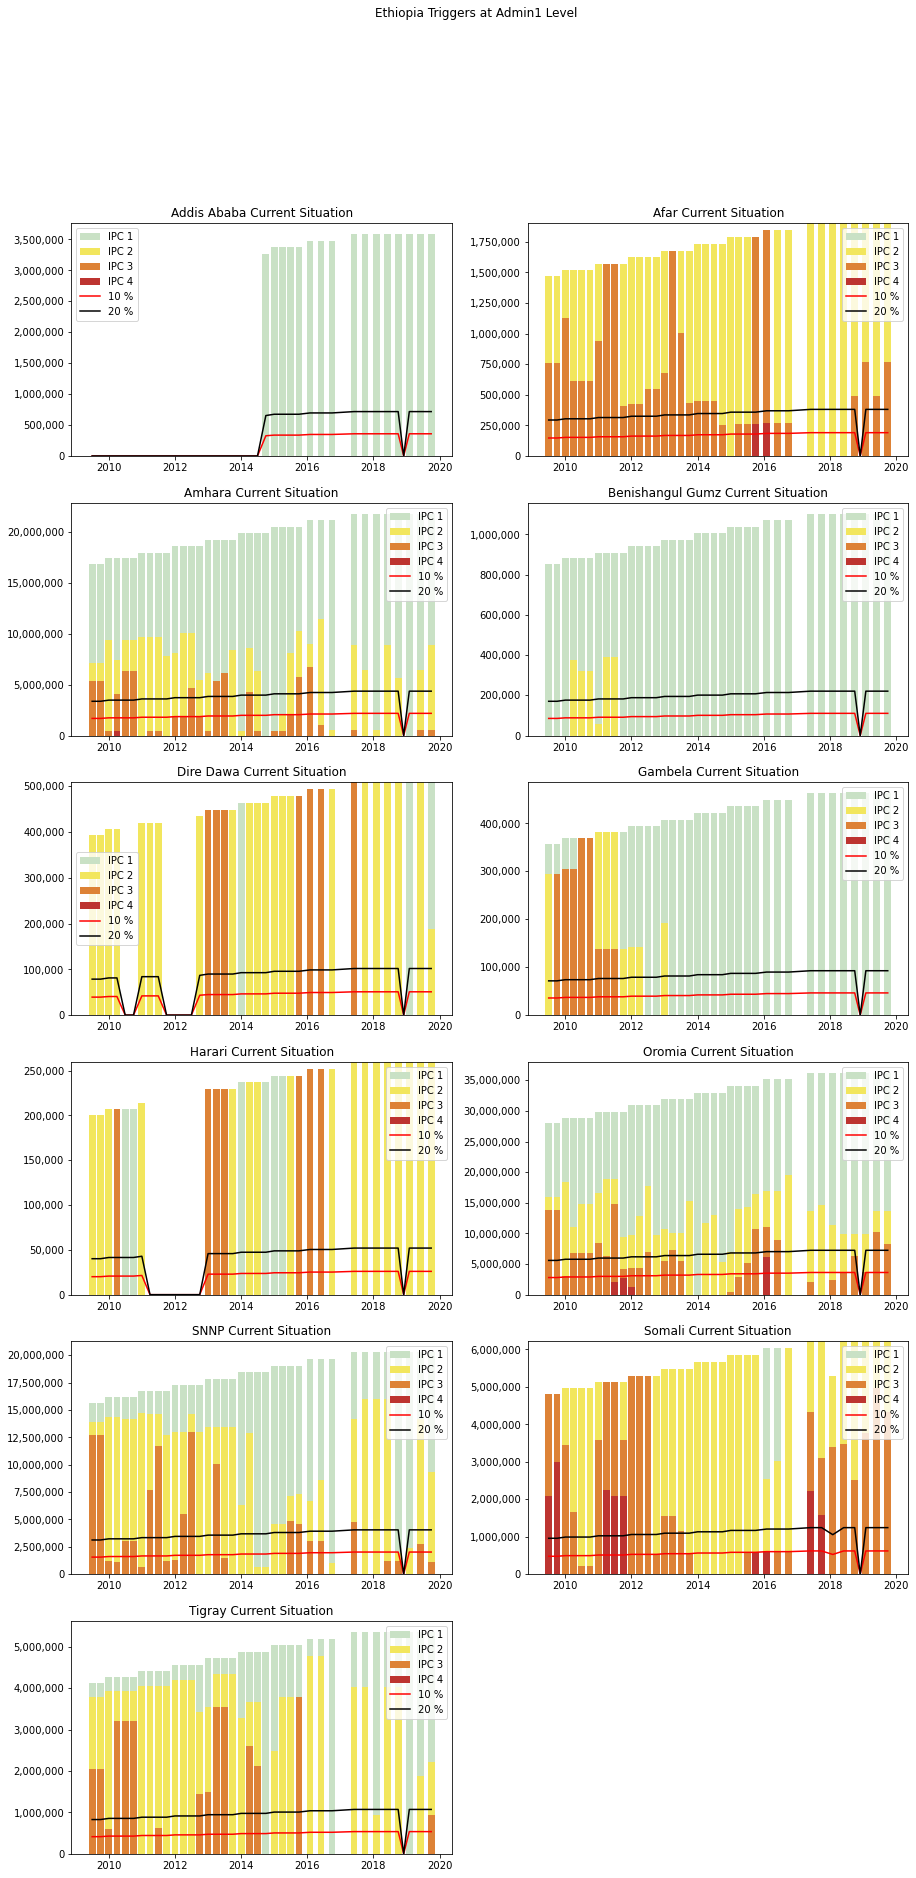

In [175]:
color_map = {1:'#C9E1C5', 2:'#F2E65D', 3:'#DD8236', 4:'#BD3430', 5:'#551010', 99: '#CCCCCC'}
width = 75
count = 1
fig, ax = plt.subplots(figsize=(15,30))
plt.suptitle('Ethiopia Triggers at Admin1 Level')
for region in df_ipcad['ADMIN1'].unique():
    ax = plt.subplot(6,2,count)
    data = df_ipcad.loc[df_ipcad['ADMIN1']==region]
    pop_data = total_pop.loc[total_pop['ADMIN1']==region]
    total = data['CS_1']+data['CS_2']+data['CS_3']+data['CS_4'].to_numpy()
    p4 = plt.bar(data['date'], data['CS_4'], width=width, color=color_map[4])
    p3 = plt.bar(data['date'], data['CS_3'], width=width, color=color_map[3], bottom=data['CS_4'].to_numpy())
    p2 = plt.bar(data['date'], data['CS_2'], width=width, color=color_map[2], bottom=(data['CS_3']+data['CS_4']).to_numpy())
    p1 = plt.bar(data['date'], data['CS_1'], width=width, color=color_map[1], bottom=(data['CS_2']+data['CS_3']+data['CS_4']).to_numpy())
    p5 = plt.plot(pop_data['date'], total/10 , color='red')
    p6 = plt.plot(pop_data['date'], total/5, color='black')
    plt.title(region + ' Current Situation')
    ax.legend((p1[0], p2[0], p3[0], p4[0], p5[0], p6[0]), ('IPC 1', 'IPC 2', 'IPC 3', 'IPC 4', '10 %', '20 %'))
    ax.get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    count+=1

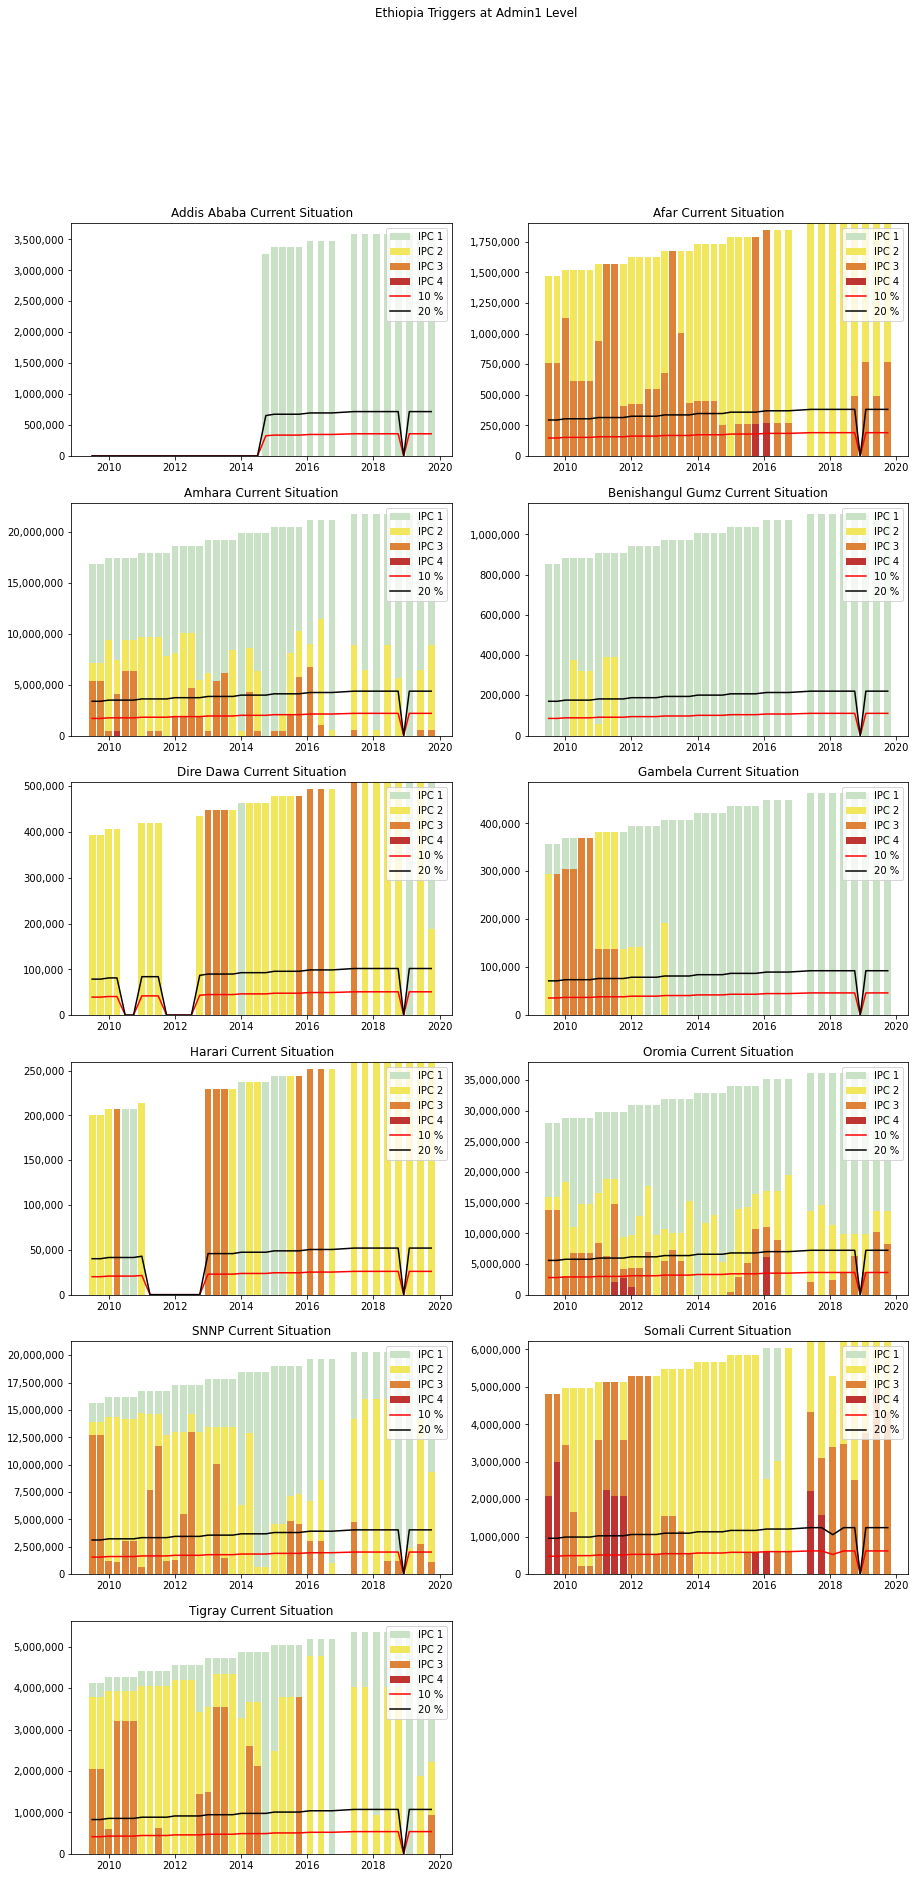

In [408]:
color_map = {1:'#C9E1C5', 2:'#F2E65D', 3:'#DD8236', 4:'#BD3430', 5:'#551010', 99: '#CCCCCC'}
width = 75
count = 1
fig, ax = plt.subplots(figsize=(15,30))
plt.suptitle('Ethiopia Triggers at Admin1 Level')
for region in df_ipcad['ADMIN1'].unique():
    ax = plt.subplot(6,2,count)
    data = df_ipcad.loc[df_ipcad['ADMIN1']==region]
    total = data['CS_1']+data['CS_2']+data['CS_3']+data['CS_4'].to_numpy()
    p4 = plt.bar(data['date'], data['CS_4'], width=width, color=color_map[4])
    p3 = plt.bar(data['date'], data['CS_3'], width=width, color=color_map[3], bottom=data['CS_4'].to_numpy())
    p2 = plt.bar(data['date'], data['CS_2'], width=width, color=color_map[2], bottom=(data['CS_3']+data['CS_4']).to_numpy())
    p1 = plt.bar(data['date'], data['CS_1'], width=width, color=color_map[1], bottom=(data['CS_2']+data['CS_3']+data['CS_4']).to_numpy())
    p5 = plt.plot(data['date'], total/10 , color='red')
    p6 = plt.plot(data['date'], total/5, color='black')
    plt.title(region + ' Current Situation')
    ax.legend((p1[0], p2[0], p3[0], p4[0], p5[0], p6[0]), ('IPC 1', 'IPC 2', 'IPC 3', 'IPC 4', '10 %', '20 %'))
    ax.get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    count+=1

### Analysis of historical triggers

#### subnational triggers
IPC3+ for at least 20% of the regional population AND EITHER: IPC4+ projected for at least 2.5% of the regional population OR: 5% increase in regional population projected to be in IPC3+

In [177]:
shape = 'Data/ET_Admin2_2014/ET_Admin2_2014.shp'
gdf = gpd.read_file(shape)
gdf.head()

,FNID,EFF_YEAR,COUNTRY,ADMIN0,ADMIN1,ADMIN1FR,ADMIN1SP,ADMIN1PT,ADMIN2,ADMIN2FR,ADMIN2SP,ADMIN2PT,ALIASES,geometry
0,ET2014A20722,2014,ET,Ethiopia,SNNPR,None,None,None,Segen,None,None,None,None,"POLYGON ((37.00893 5.20392, 37.00860 5.21044, ..."
1,ET2014A20411,2014,ET,Ethiopia,Oromia,None,None,None,Bale,None,None,None,None,"POLYGON ((41.52576 7.95226, 41.52766 7.94139, ..."
2,ET2014A20708,2014,ET,Ethiopia,SNNPR,None,None,None,Sheka,None,None,None,None,"POLYGON ((35.60882 7.81575, 35.60975 7.81142, ..."
3,ET2014A20412,2014,ET,Ethiopia,Oromia,None,None,None,Borena,None,None,None,None,"POLYGON ((37.91887 6.58472, 37.92165 6.57858, ..."
4,ET2014A20704,2014,ET,Ethiopia,SNNPR,None,None,None,Sidama,None,None,None,None,"POLYGON ((39.12953 6.33941, 39.12851 6.32545, ..."


In [178]:
# JP new_trigger = cs at ipc-3-4 >= 20% pop (T1) and ML1 at 4 >= 2.5% pop (T3) subnational
#new trigger: subnational scenario 1
df_sn1 = df_ipcad.loc[(df_ipcad['trigger_CS_20']==1)&(df_ipcad['trigger_ML1_2']==1)]
df_sn1['date'] = pd.to_datetime(df_sn1['date'])
df_sn1['year'] = df_sn1['date'].apply(lambda x: x.year)
df_sn1['month'] = df_sn1['date'].dt.month

In [179]:
df_sn1.head()

,date,ADMIN1,CS_1,CS_2,CS_3,CS_4,ML1_1,ML1_2,ML1_3,ML1_4,...,ML2_3,ML2_4,total_pop,trigger_CS_20,trigger_ML1_5,trigger_ML1_2,trigger_ML1_30,trigger_ML1_5i,year,month
9,2009-07-01,Somali,0,0,2704481,2093416,0,0,1809166,2988731,...,1248133,2093416,4797897,1,1,1,1,0,2009,7
23,2010-01-01,Afar,0,391618,1128077,0,0,0,1006561,513134,...,1295176,224519,1519695,1,1,1,1,1,2010,1
27,2010-01-01,Gambela,65129,0,304202,0,65129,0,0,304202,...,0,304202,369331,1,1,1,1,0,2010,1
31,2010-01-01,Somali,0,1505737,3454869,0,0,0,3698250,1262356,...,4446532,514074,4960606,1,1,1,1,1,2010,1
86,2011-04-01,Somali,0,0,2890266,2237225,0,0,2890266,2237225,...,2890266,2237225,5127491,1,1,1,1,0,2011,4


In [180]:
#calculate when and for which admin1 regions the threshold was past
df_sn1.groupby(['year', 'month'], as_index=False)['ADMIN1'].agg(lambda x: list(x))

,year,month,ADMIN1
0,2009,7,[Somali]
1,2010,1,"[Afar, Gambela, Somali]"
2,2011,4,[Somali]
3,2011,7,"[Oromia, Somali]"
4,2015,10,[Afar]
5,2016,2,"[Afar, Oromia]"
6,2017,6,[Somali]
7,2017,10,[Somali]


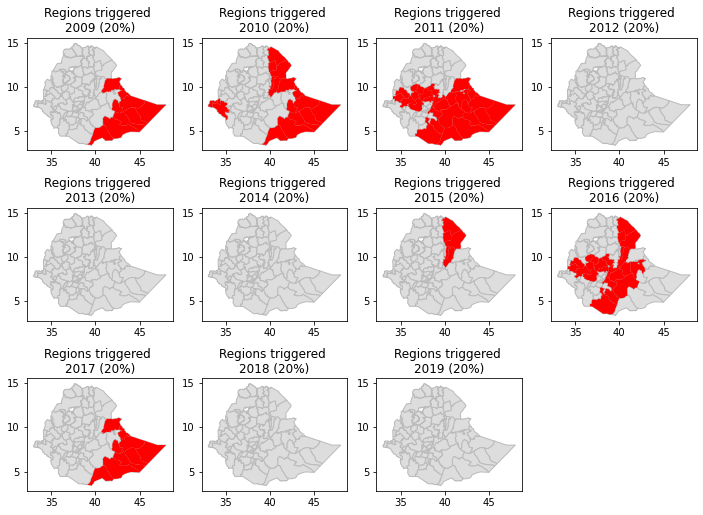

In [181]:
count = 1
f, ax = plt.subplots(figsize=(12,12))
for d in ['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']:
    ax2 = plt.subplot(4, 4, count)
    gdf.plot(ax=ax2, column='ADMIN0', color='#DDDDDD', edgecolor='#BBBBBB')
    regions = df_sn1['ADMIN1'].loc[df_sn1['year'].astype(str)==d]
#     print(d, regions)
    gdf.loc[gdf['ADMIN1'].isin(regions)].plot(ax=ax2, color='red')
    plt.title("Regions triggered \n"+str(d)+' (20%)')
    count+=1
plt.show()

In [182]:
#TV: what is this doing??
def get_pop(date):
    d = str(date).split('-')
    if '2009' in d:
        return 11500000
    elif '2010' in d:
        return 11890000
    elif '2011' in d:
        return 12290000
    elif '2012' in d:
        return 12710000
    elif '2013' in d:
        return 13130000
    elif '2014' in d:
        return 13570000
    elif '2015' in d:
        return 14010000
    elif '2016' in d:
        return 14450000
    else:
        return 14900000

In [183]:
total_pop = pd.DataFrame(columns=['date', 'total_pop'])
total_pop['date'] = df_ipcad['date'].unique()
total_pop['total_pop'] = total_pop['date'].apply(lambda x: get_pop(x))
total_pop['perc_20'] = total_pop['total_pop']/5 # 20% threshold
total_pop['perc_10'] = total_pop['total_pop']/10 # 20% threshold
total_pop['perc_5'] = total_pop['total_pop']/20 # 5% threshold
total_pop['perc_2_5'] = total_pop['total_pop']/40 # 2.5% threshold
total_pop.head()

,date,total_pop,perc_20,perc_10,perc_5,perc_2_5
0,2009-07-01,11500000,2300000.000,1150000.000,575000.000,287500.000
1,2009-10-01,11500000,2300000.000,1150000.000,575000.000,287500.000
2,2010-01-01,11890000,2378000.000,1189000.000,594500.000,297250.000
3,2010-04-01,11890000,2378000.000,1189000.000,594500.000,297250.000
4,2010-07-01,11890000,2378000.000,1189000.000,594500.000,297250.000


In [184]:
# JP: SUBNATIONAL trigger 
# if CS for IPC3-4 at 20%+ and (ML1 for IPC4 at 2.5%+ OR ML1 for IPC 3-4 >= 5% increase over CS 3-4)
df_snc=df_ipcad[(df_ipcad['trigger_CS_20'] == 1) & ((df_ipcad['trigger_ML1_2'] == 1) | (df_ipcad['trigger_ML1_5i'] == 1))].groupby('date')['ADMIN1'].agg(lambda x: list(x))
df_snc

date
2009-07-01                   [Somali]
2010-01-01    [Afar, Gambela, Somali]
2011-04-01                   [Somali]
2011-07-01           [Oromia, Somali]
2012-04-01                     [Afar]
2013-01-01                   [Somali]
2015-10-01                     [Afar]
2016-02-01     [Afar, Amhara, Oromia]
2017-06-01                   [Somali]
2017-10-01                   [Somali]
2019-02-01                   [Somali]
Name: ADMIN1, dtype: object

In [193]:
#this is the one missing from current triggers compared to the proposal document
b=df_ipcad[(df_ipcad.date=="2010-04") & (df_ipcad.ADMIN1=="Amhara")]

In [189]:
b

,date,ADMIN1,CS_1,CS_2,CS_3,CS_4,ML1_1,ML1_2,ML1_3,ML1_4,ML2_1,ML2_2,ML2_3,ML2_4,total_pop,trigger_CS_20,trigger_ML1_5,trigger_ML1_2,trigger_ML1_30,trigger_ML1_5i
35,2010-04-01,Amhara,10001700,3301113,3673319,412125,10001700,3301113,3673319,412125,7985218,1843464,7147450,412125,17388257,1,1,0,0,0


In [192]:
b.ML1_4/b.total_pop*100

35   2.370
dtype: float64

#### National roll-up

In [62]:
# JP NATIONAL roll-up with 5% change
df_nr = df_ipcad[(df_ipcad['trigger_CS_20'] == 1) & ((df_ipcad['trigger_ML1_2'] == 1) | (df_ipcad['trigger_ML1_5i'] == 1))].groupby('date')['ADMIN1'].agg(nbr_regions = lambda x: len(x))
df_nr2=df_nr[df_nr['nbr_regions'] >= 2]
df_nr2

,nbr_regions
date,
2010-01-01,3
2011-07-01,2
2016-02-01,3


#### National aggregate

In [63]:
df_national = df_ipcad[['date', 'total_pop']+cols_ipc].groupby('date').agg('sum').reset_index()

In [64]:
df_national.head()

,date,total_pop,CS_1,CS_2,CS_3,CS_4,ML1_1,ML1_2,ML1_3,ML1_4,ML2_1,ML2_2,ML2_3,ML2_4
0,2009-07-01,72613550.839,24596714.027,8450795.067,37472623.423,2093418.322,24596714.027,8156568.725,36871533.859,2988734.228,20921821.879,43127796.275,6470514.362,2093418.322
1,2009-10-01,72613550.839,24596714.027,8156568.725,36871533.859,2988734.228,20921821.879,44462937.785,7228791.174,0.000,20921821.879,41536739.631,10154989.329,0.000
2,2010-01-01,75076097.346,21631344.534,43228458.636,10216294.175,0.000,23423020.705,28021511.720,20539382.894,3092182.027,25206057.074,13230963.776,26290042.041,10349034.454
3,2010-04-01,75076097.346,30628205.097,26444724.557,17591041.938,412125.754,30628205.097,26444724.557,17591041.938,412125.754,28611722.542,23052232.252,23000016.798,412125.754
4,2010-07-01,74669987.613,25134405.062,28922444.152,20613138.399,0.000,25134405.062,28922444.152,20613138.399,0.000,25754088.720,41332089.819,7583809.074,0.000


In [65]:
df_national["trigger_CS_20"]=df_national.apply(get_trigger_CS_20,axis=1)
df_national["trigger_ML1_5"]=df_national.apply(get_trigger_ML1_5,axis=1)
df_national["trigger_ML1_2"]=df_national.apply(get_trigger_ML1_2,axis=1)
df_national["trigger_ML1_30"]=df_national.apply(get_trigger_ML1_30,axis=1)
df_national["trigger_ML1_5i"]=df_national.apply(get_trigger_ML1_5i,axis=1)

In [66]:
df_national.head()

,date,total_pop,CS_1,CS_2,CS_3,CS_4,ML1_1,ML1_2,ML1_3,ML1_4,ML2_1,ML2_2,ML2_3,ML2_4,trigger_CS_20,trigger_ML1_5,trigger_ML1_2,trigger_ML1_30,trigger_ML1_5i
0,2009-07-01,72613550.839,24596714.027,8450795.067,37472623.423,2093418.322,24596714.027,8156568.725,36871533.859,2988734.228,20921821.879,43127796.275,6470514.362,2093418.322,1,1,1,1,0
1,2009-10-01,72613550.839,24596714.027,8156568.725,36871533.859,2988734.228,20921821.879,44462937.785,7228791.174,0.000,20921821.879,41536739.631,10154989.329,0.000,1,1,0,0,0
2,2010-01-01,75076097.346,21631344.534,43228458.636,10216294.175,0.000,23423020.705,28021511.720,20539382.894,3092182.027,25206057.074,13230963.776,26290042.041,10349034.454,0,1,1,1,1
3,2010-04-01,75076097.346,30628205.097,26444724.557,17591041.938,412125.754,30628205.097,26444724.557,17591041.938,412125.754,28611722.542,23052232.252,23000016.798,412125.754,1,1,0,0,0
4,2010-07-01,74669987.613,25134405.062,28922444.152,20613138.399,0.000,25134405.062,28922444.152,20613138.399,0.000,25754088.720,41332089.819,7583809.074,0.000,1,1,0,0,0


In [67]:
df_national[(df_national['trigger_CS_20'] == 1) & ((df_national['trigger_ML1_2'] == 1) | (df_national['trigger_ML1_5i'] == 1))]

,date,total_pop,CS_1,CS_2,CS_3,CS_4,ML1_1,ML1_2,ML1_3,ML1_4,ML2_1,ML2_2,ML2_3,ML2_4,trigger_CS_20,trigger_ML1_5,trigger_ML1_2,trigger_ML1_30,trigger_ML1_5i
0,2009-07-01,72613550.839,24596714.027,8450795.067,37472623.423,2093418.322,24596714.027,8156568.725,36871533.859,2988734.228,20921821.879,43127796.275,6470514.362,2093418.322,1,1,1,1,0
7,2011-04-01,77387311.548,22118371.563,34002745.474,19028967.452,2237227.059,22118371.563,34002745.474,19028967.452,2237227.059,22362464.985,20322238.378,32465381.126,2237227.059,1,1,1,0,0
8,2011-07-01,77387311.548,22118371.563,20863842.181,30312786.801,4092311.003,22118371.563,20863842.181,30312786.801,4092311.003,22185691.894,48587850.185,6613769.469,0.000,1,1,1,1,0
26,2016-02-01,94717860.832,52219751.369,18383872.849,17098622.933,7015613.681,52219751.369,13487741.527,21493894.950,7516472.987,48048411.681,11862070.946,26738306.185,8069072.020,1,1,1,1,1


In [68]:
df_national[(df_national['trigger_CS_20'] == 1) & ((df_national['trigger_ML1_2'] == 1) | (df_national['trigger_ML1_5i'] == 1))]['date'].agg(lambda x: list(x))

[Timestamp('2009-07-01 00:00:00'),
 Timestamp('2011-04-01 00:00:00'),
 Timestamp('2011-07-01 00:00:00'),
 Timestamp('2016-02-01 00:00:00')]

In [69]:
#checking if 2017-6 reached the requirements. But according to this data it didn't
df_national[df_national.date=="2017-6"]

,date,total_pop,CS_1,CS_2,CS_3,CS_4,ML1_1,ML1_2,ML1_3,ML1_4,ML2_1,ML2_2,ML2_3,ML2_4,trigger_CS_20,trigger_ML1_5,trigger_ML1_2,trigger_ML1_30,trigger_ML1_5i
29,2017-06-01,97667552.000,47963513.000,37574503.000,9895917.000,2233619.000,50490476.000,31950680.000,12992777.000,2233619.000,75988677.000,18580606.000,864650.000,2233619.000,0,1,0,0,1


Same as above

In [70]:
## JP: national aggrregate with projected 5% increase
# trigger_1 and trigger_3 defined above

# Projection: 5% increase in pop in IPC3+ in 1-3 months
def get_trigger_jp(row):
    if row['total_pop'] == 0 or (row['ml_1_3'] + row['ml_1_4'] == 0):
        return 0
    if  row['ml_1_3'] + row['ml_1_4'] >= (row['cs_3'] + row['cs_4'])*1.05:
        return 1
    else:
        return 0

national_grouped['trigger_1'] = national_grouped.apply(get_trigger_1, axis=1)
national_grouped['trigger_3'] = national_grouped.apply(get_trigger_3, axis=1)
national_grouped['trigger_jp'] = national_grouped.apply(get_trigger_jp, axis=1)
national_grouped.head(10)



NameError: name 'national_grouped' is not defined

In [ ]:
# JP: replicate eleonore's findings for national-aggregate

print("Eleonore's list: 7/2009, 10/2009, 4/2011, 7/2011, 2/2016, 6/2017)")
national_grouped[(national_grouped['trigger_1'] == 1) & (national_grouped['trigger_3'] == 1)]
                                                         

In [ ]:
# NOTE: cannot replicate eleonore's 10/2009 and 6/2017 with this approach (see above)
## JP: past triggers with national aggregate including 5% increase

# if CS for IPC3-4 at 20%+ and (ML1 for IPC4 at 2.5%+ OR ML1 for IPC 3-4 >= 5% increase over CS 3-4)
national_grouped[(national_grouped['trigger_1'] == 1) & ((national_grouped['trigger_3'] == 1) | (national_grouped['trigger_jp'] == 1))]['date'].agg(lambda x: list(x))    

In [ ]:
color_map = {1:'#C9E1C5', 2:'#F2E65D', 3:'#DD8236', 4:'#BD3430', 5:'#551010', 99: '#CCCCCC'}
trigger_years = ['2009-07-01', '2009-10-10', '2011-04-01', '2011-07-01', '2016-02-01', '2017-06-01']
fig, ax = plt.subplots(figsize=(14,8))
pd.set_option('display.float_format', lambda x: '%.3f' % x)
width=75
p4 = plt.bar(df_national['date'], df_national['CS_4'], width=width, color=color_map[4])
p3 = plt.bar(df_national['date'], df_national['CS_3'], width=width, color=color_map[3], 
            bottom=df_national['CS_4'])
p2 = plt.bar(df_national['date'], df_national['CS_2'], width=width, color=color_map[2],
            bottom=(df_national['CS_4']+df_national['CS_3']))
p1 = plt.bar(df_national['date'], df_national['CS_1'], width=width, color=color_map[1],
            bottom=(df_national['CS_4']+df_national['CS_3']+df_national['CS_2']))

for year in trigger_years:
    plt.axvline(year, color='red')
#p5 = plt.plot(total_pop['date'], total_pop['perc_2_5'], color='red')
#p6 = plt.plot(total_pop['date'], total_pop['perc_10'], color='blue')
#p7 = plt.plot(total_pop['date'], total_pop['perc_20'], color='black')


plt.ylabel('Population')
plt.title('Population in each IPC phase by year for Ethiopia')
plt.legend((p1[0], p2[0], p3[0], p4[0]), ('IPC 1', 'IPC 2', 'IPC 3', 'IPC 4'))

plt.xticks(df_ipcad['date'].unique(), rotation=45, ha="right")

ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))


plt.show()

In [ ]:
df_nationalc = df_national[df_national['date'] != '2018-12-01']

In [ ]:
color_map = {1:'#C9E1C5', 2:'#F2E65D', 3:'#DD8236', 4:'#BD3430', 5:'#551010', 99: '#CCCCCC'}

fig, ax = plt.subplots(figsize=(14,8))
pd.set_option('display.float_format', lambda x: '%.3f' % x)
width=75
p4 = plt.bar(df_nationalc['date'], df_nationalc['CS_4'], width=width, color=color_map[4])
p3 = plt.bar(df_nationalc['date'], df_nationalc['CS_3'], width=width, color=color_map[3], 
            bottom=df_nationalc['CS_4'])
p2 = plt.bar(df_nationalc['date'], df_nationalc['CS_2'], width=width, color=color_map[2],
            bottom=(df_nationalc['CS_4']+df_nationalc['CS_3']))
p1 = plt.bar(df_nationalc['date'], df_nationalc['CS_1'], width=width, color=color_map[1],
            bottom=(df_nationalc['CS_4']+df_nationalc['CS_3']+df_nationalc['CS_2']))

p5 = plt.plot(df_nationalc['date'], df_nationalc['total_pop']/40, color='red')
p6 = plt.plot(df_nationalc['date'], df_nationalc['total_pop']/3.33, color='blue')
p7 = plt.plot(df_nationalc['date'], df_nationalc['total_pop']/5, color='black')

for year in trigger_years:
    plt.axvline(year, color='red')


plt.ylabel('Population')
plt.title('Population in each IPC phase by year for Ethiopia\n Trigger at (20%)')
plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0], p6[0], p7[0]), ('IPC 1', 'IPC 2', 'IPC 3', 'IPC 4', '2.5 %', '30 %', '20 %'))

plt.xticks(df_ipcad['date'].unique(), rotation=45, ha="right")

ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))


plt.show()

In [ ]:
# thresholds = ['2009-07-01', '2009-10-01', '2010-04-01', '2010-07-01','2010-10-01','2011-04-01', 
#               '2011-07-01','2017-06-01', '2018-02-01','2018-06-01']
# color_map = {1:'#C9E1C5', 2:'#F2E65D', 3:'#DD8236', 4:'#BD3430', 5:'#551010', 99: '#CCCCCC'}
# fig, ax = plt.subplots(figsize=(14,8))
# pd.set_option('display.float_format', lambda x: '%.3f' % x)
# width=75
# for t in thresholds:
#     plt.axvline(pd.to_datetime(t), color='red', lw=10, ls='--', alpha=0.3)
# p1 = plt.bar(grouped['date'].loc[grouped['CS']==1], grouped['T'].loc[grouped['CS']==1], width=width, color=color_map[1])
# p2 = plt.bar(grouped['date'].loc[grouped['CS']==2], grouped['T'].loc[grouped['CS']==2], width=width, color=color_map[2])
# p3 = plt.bar(grouped['date'].loc[grouped['CS']==3], grouped['T'].loc[grouped['CS']==3], width=width, color=color_map[3])
# p4 = plt.bar(grouped['date'].loc[grouped['CS']==4], grouped['T'].loc[grouped['CS']==4], width=width, color=color_map[4])
# p5 = plt.plot(total_pop['date'], total_pop['perc_2_5'], color='red')
# p6 = plt.plot(total_pop['date'], total_pop['perc_20'], color='black')


# plt.ylabel('Population')
# plt.title('Population in each IPC phase by year for Chad with Triggers')
# plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0], p6[0]), ('IPC 1', 'IPC 2', 'IPC 3', 'IPC 4', '2.5 %', '20 %'))

# plt.xticks(grouped['date'].unique(), rotation=45, ha='right')

# ax.get_yaxis().set_major_formatter(
#     matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

# #ax.ticklabel_format(useOffset=False)

# plt.show()

In [ ]:
# #shapefile = '../FEWSNET/Southern Africa/SA_'+d+'_CS.shp'
#     #Read shapefile using Geopandas
# #   gdf = gpd.read_file(shapefile)
# #    gdf['color'] = gdf['CS'].apply(lambda x: set_color(x))
# #    gdf.plot(color = gdf['color'])
# combined.head()

In [ ]:
# for row in converted.iterrows():
#     print(row)

In [ ]:
# grouped.loc[grouped['CS']==3]

In [ ]:
# df.loc[df['CS']==3]

In [ ]:
# t = converted.loc[(converted['date']=='201307')&(converted['ADMIN2'].astype(str)!='nan')]
# t['ADMIN2'].unique().size

In [185]:
# Next steps
# Extend time series
# Add drought events
# Add threshold (proposed)
# Add food prices
# Add total population

### Percentage correct

In [187]:
df_ipc

,Unnamed: 0,date,ADMIN0,ADMIN1,ADMIN2,CS,ML1,ML2
0,1373,2019-02-01,Ethiopia,SNNPR,Segen,2.000,3.000,2.000
1,6004,2019-02-01,Ethiopia,Oromia,Bale,2.000,3.000,2.000
2,1375,2019-02-01,Ethiopia,Oromia,Borena,2.000,2.000,2.000
3,3,2019-02-01,Ethiopia,Somali,Jarar,3.000,3.000,3.000
4,1930,2019-02-01,Ethiopia,Oromia,East Wellega,1.000,1.000,1.000
...,...,...,...,...,...,...,...,...
2883,4673,2018-12-01,Ethiopia,Amhara,North Gondar,99.000,99.000,99.000
2884,4648,2018-12-01,Ethiopia,Amhara,West Gojam,99.000,99.000,99.000
2885,4610,2018-12-01,Ethiopia,Amhara,Awi,99.000,99.000,99.000
2886,4663,2018-12-01,Ethiopia,Benshangul Gumuz,Pawe,99.000,99.000,99.000


### Population loss debugging

In [12]:
len(eth_pop.admin2Name_en.unique())

90

In [13]:
len(df_ipc.ADMIN2.unique())

76

In [14]:
#check for NaN values
eth_pop[eth_pop.isna().any(axis=1)]

,admin2Name_en,admin2Pcode,admin1Name_en,admin1Pcode,admin0Name_en,admin0Pcode,Total,Male,Female,T_00_17,T_18_60,T_60plus


In [15]:
#check for NaN values
df_ipc[df_ipc.isna().any(axis=1)]

,Unnamed: 0,date,ADMIN0,ADMIN1,ADMIN2,CS,ML1,ML2


In [16]:
pop_notmap=np.setdiff1d(eth_pop.admin2Name_en.unique(),list(admin2_mapping.keys()))

In [17]:
ipc_notmap=np.setdiff1d(df_ipc.ADMIN2.unique(),list(admin2_mapping.values()))

In [18]:
#ipc admin2 regions that are not assigned any population data admin2 regions
np.setdiff1d(ipc_notmap,pop_notmap)

array(['Argoba', 'East Gojam', 'Gujii', 'Horo Guduru', 'Kelem',
       'Kembata Tembaro', 'Konta', 'Pawe', 'Segen', 'Silltie',
       'South West Shewa', 'South Wollo', 'Yem'], dtype=object)

In [19]:
#population admin2 regions that are not assigned to any ipc data admin2 regions
np.setdiff1d(pop_notmap,ipc_notmap)

array(['Alle', 'Amaro', 'Buno Bedele', 'Burji', 'Central Gondar', 'Daawa',
       'Derashe', 'East Gojam ', 'Erer', 'Finfine Special', 'Guji',
       'Horo Gudru Wellega', 'Kelem Wellega ', 'Kembata Tibaro', 'Konso',
       'Konta Special', 'Mao Komo Special', 'Mekele Special', 'Mirab Omo',
       'Siltie', 'South Wello', 'South West Shewa ', 'West Gondar',
       'West Guji', 'Yem Special'], dtype=object)

In [20]:
#is correct to have 91 admin2 regions?
eth_pop.shape

(91, 12)

In [21]:
eth_pop.groupby("admin1Name_en").sum()

,Total,Male,Female,T_00_17,T_18_60,T_60plus
admin1Name_en,,,,,,
Addis Ababa,3585647,1696365,1889283,1900393,1511350,173904
Afar,1904414,1040443,863972,1009339,802711,92364
Amhara,21790172,10921526,10868647,11548790,9184559,1056824
Benishangul Gumz,1102849,559628,543221,584510,464851,53488
Dire Dawa,508918,255552,253368,269727,214509,24682
Gambela,462832,241205,221626,245301,195084,22448
Harari,260022,131068,128954,137812,109599,12611
Oromia,37843293,19096554,18746733,20056943,15950944,1835399
SNNP,20262695,10045198,10217499,10739230,8540729,982741


In [22]:
eth_pop[eth_pop["admin2Name_en"]=="Segen"]

,admin2Name_en,admin2Pcode,admin1Name_en,admin1Pcode,admin0Name_en,admin0Pcode,Total,Male,Female,T_00_17,T_18_60,T_60plus


In [23]:
df_ipc[df_ipc["ADMIN2"]=="Segen"].head()
#This shows that eth_pop --> df_ipc admin2 mapping is not complete since "Segen" does appear in df_ipc but not in eth_pop..
#Not sure how to solve this, but we don't use Admin2 levels later on, so can already aggregate to Admin1 before merging?

,Unnamed: 0,date,ADMIN0,ADMIN1,ADMIN2,CS,ML1,ML2
0,1373,2019-02-01,Ethiopia,SNNPR,Segen,2.000,3.000,2.000
76,31,2010-10-01,Ethiopia,SNNPR,Segen,2.000,2.000,2.000
152,97,2014-07-01,Ethiopia,SNNPR,Segen,1.000,1.000,1.000
228,223,2010-01-01,Ethiopia,SNNPR,Segen,3.000,3.000,4.000
304,160,2009-10-01,Ethiopia,SNNPR,Segen,3.000,3.000,3.000


In [24]:
#We loosing 22 million population so clearly not going as it should go, but for now let it be. 
#from HDX it seems, with the population data there is also a csv with boundary shapes so maybe we could use those instead of this mapping..

In [25]:
#I am proposing that instead of the current admin file to map from livelihoods, we immediately use the population data file

### Old stuff

In [105]:
#TV: this is not being used right now
# def get_previous_3(row, df):
#     date = row['date']
#     try:
#         previous =  row['date'] + pd.DateOffset(months=-3)
#         previous_row = df.loc[(df['date']==previous)&(df['ADMIN1']==row['ADMIN1'])&(df['ML1']==row['ML1'])]
#         return previous_row['adjusted_population']
#     except:
#         return None
    
# def get_previous_6(row, df):
#     date = row['date']
#     try:
#         previous =  row['date'] + pd.DateOffset(months=-6)
#         previous_row = df.loc[(df['date']==previous)&(df['ADMIN1']==row['ADMIN1'])&(df['ML2']==row['CS'])]
#         return previous_row['adjusted_population']
#     except:
#         return None

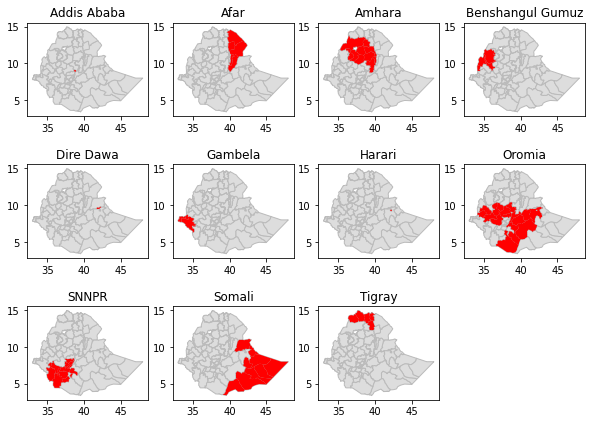

In [137]:
# # JP BELOW: location of each region, no metric visualized
# #TV: removing for now
# count = 1
# f, ax = plt.subplots(figsize=(10,10))
# for region in df_ipcad['ADMIN1'].unique():
#     ax2 = plt.subplot(4, 4, count)
#     gdf.plot(ax=ax2, column='ADMIN0', color='#DDDDDD', edgecolor='#BBBBBB')
#     gdf.loc[gdf['ADMIN1']==region].plot(ax=ax2,color='red')
#     plt.title(region)
#     count+=1
# plt.show()

In [ ]:

# #TV: where is this trigger in the scenarios? For now leaving it out..
# # JP new_trigger_30 = ML1 (30 days) at 3 and 4 is >= 33.33% pop (T4)
# new_trigger_30 = df_ipcad.loc[(df_ipcad['trigger_ML_30']==1)]
# new_trigger_30['date'] = pd.to_datetime(new_trigger_30['date'])
# new_trigger_30['year'] = new_trigger_30['date'].apply(lambda x: x.year)

# #jp addition:
# new_trigger_30['month'] = new_trigger_30['date'].dt.month

In [142]:
#TV: skipping this 30 trigger for now
# count = 1
# f, ax = plt.subplots(figsize=(12,12))
# for d in ['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']:
#     ax2 = plt.subplot(4, 4, count)
#     gdf.plot(ax=ax2, column='ADMIN0', color='#DDDDDD', edgecolor='#BBBBBB')
#     regions = new_trigger_30['ADMIN1'].loc[new_trigger_30['year'].astype(str)==d]
#     gdf.loc[gdf['ADMIN1'].isin(regions)].plot(ax=ax2, color='red')
#     plt.title("Regions triggered \n"+str(d)+' (30%)')
#     count+=1
# plt.show()

In [143]:
# #TV: what is the goal of this?? 
# #If more than one region triggered in a year then color those red
# #If 1 or none regions triggered in a year, color them orange and change heading??
# #Leaving out for now
# count = 1
# f, ax = plt.subplots(figsize=(12,12))
# for d in ['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']:
#     ax2 = plt.subplot(4, 4, count)
#     gdf.plot(ax=ax2, column='ADMIN0', color='#DDDDDD', edgecolor='#BBBBBB')
#     regions = df_sn1['ADMIN1'].loc[df_sn1['year'].astype(str)==d].unique()
#     if len(regions) > 1:
#         gdf.loc[gdf['ADMIN1'].isin(regions)].plot(ax=ax2, color='red')
#         plt.title("Regions triggered \n"+str(d)+' (20%)')
#     else:
#         gdf.loc[gdf['ADMIN1'].isin(regions)].plot(ax=ax2, color='orange')
#         plt.title("Regions not triggered \n"+str(d)+' (20%)')
#     count+=1
# plt.show()